### Character-level recurrent sequence-to-sequence model

In this notebook we are going to learn ho to perform Character-level recurrent sequence-to-sequence translation using the short english and short french sentences. This model will translate text from french to english character by character. 

### Imports

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

### Mounting the Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os, time, random, math

### Data
I've uploaded the data on my google drive as usaual so that i can easly load it here in google colab. Go ahead and download the data and unzip it using the following commands:
```
!!curl -O http://www.manythings.org/anki/fra-eng.zip
!!unzip fra-eng.zip
```

### Hyper Params

In [4]:
BATCH_SIZE = 65
EPOCHS  = 100
LATENT_DIM = 256
NUM_SAMPLES = 100_000

data_path = "fra.txt"
base_path = '/content/drive/My Drive/NLP Data/seq2seq/en-fr'

### Data Preparation.

The code cell bellow was grabed from the tutorial that i was following. I only changed few things.
1. NUM_SAMPLES variable
2. Our target is english.

In [5]:

input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(os.path.join(base_path, data_path), "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[: min(NUM_SAMPLES, len(lines) - 1)]:
    target_text, input_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0


Number of samples: 100000
Number of unique input tokens: 104
Number of unique output tokens: 80
Max sequence length for inputs: 76
Max sequence length for outputs: 31


### Building the model.

In [6]:
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens), name="encoder_inputs")
encoder = keras.layers.LSTM(LATENT_DIM, return_state=True, name="encoder_lstm")
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]


decoder_inputs = keras.Input(shape=(None, num_decoder_tokens), name="decoder_inputs")

"""
We set up our decoder to return full output sequences,
and to return internal states as well. We don't use the
return states in the training model, but we will use them in inference.
"""
decoder_lstm = keras.layers.LSTM(LATENT_DIM, return_sequences=True,
                                 return_state=True, name="decoder_lstm")
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax", name="decoder_outputs")
decoder_outputs = decoder_dense(decoder_outputs)

# MODEL

model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs, name="model")
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, None, 104)]  0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None, 80)]   0                                            
__________________________________________________________________________________________________
encoder_lstm (LSTM)             [(None, 256), (None, 369664      encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_lstm (LSTM)             [(None, None, 256),  345088      decoder_inputs[0][0]             
                                                                 encoder_lstm[0][1]           

### Let's plot the model so that we can visually see it.

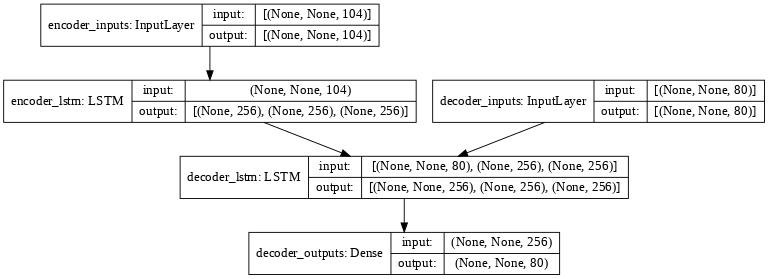

In [7]:
keras.utils.plot_model(model, dpi=66, show_shapes=True)

### Now let's train the model.

In [8]:
model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2,
)


Epoch 1/100
1231/1231 [==============================] - 30s 17ms/step - loss: 1.4471 - accuracy: 0.5891 - val_loss: 1.6505 - val_accuracy: 0.5066
Epoch 2/100
1231/1231 [==============================] - 20s 16ms/step - loss: 1.0426 - accuracy: 0.6870 - val_loss: 1.4152 - val_accuracy: 0.5732
Epoch 3/100
1231/1231 [==============================] - 20s 16ms/step - loss: 0.9138 - accuracy: 0.7224 - val_loss: 1.2634 - val_accuracy: 0.6139
Epoch 4/100
1231/1231 [==============================] - 20s 16ms/step - loss: 0.8464 - accuracy: 0.7418 - val_loss: 1.1822 - val_accuracy: 0.6389
Epoch 5/100
1231/1231 [==============================] - 21s 17ms/step - loss: 0.7782 - accuracy: 0.7627 - val_loss: 1.1102 - val_accuracy: 0.6615
Epoch 6/100
1231/1231 [==============================] - 21s 17ms/step - loss: 0.7224 - accuracy: 0.7786 - val_loss: 1.0736 - val_accuracy: 0.6726
Epoch 7/100
1231/1231 [==============================] - 21s 17ms/step - loss: 0.6818 - accuracy: 0.7908 - val_loss: 1

### Model Inference

Again the code cell bellow was copied from the referenced tutorial.

In [11]:
encoder_inputs = model.input[0]  
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]
decoder_state_input_h = keras.Input(shape=(LATENT_DIM,), name="input_3")
decoder_state_input_c = keras.Input(shape=(LATENT_DIM,), name="input_4")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence

In [12]:
for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)

-
Input sentence: Va !
Decoded sentence: Go ahead.

-
Input sentence: Marche.
Decoded sentence: That's a for stupid.

-
Input sentence: Bouge !
Decoded sentence: Get out.

-
Input sentence: Salut !
Decoded sentence: In this back.

-
Input sentence: Salut.
Decoded sentence: Well our teach.

-
Input sentence: Cours !
Decoded sentence: Run!

-
Input sentence: Courez !
Decoded sentence: Run.

-
Input sentence: Prenez vos jambes à vos cous !
Decoded sentence: Take what you should do.

-
Input sentence: File !
Decoded sentence: Run away.

-
Input sentence: Filez !
Decoded sentence: Run for it!

-
Input sentence: Cours !
Decoded sentence: Run.

-
Input sentence: Fuyez !
Decoded sentence: Go ahead!

-
Input sentence: Fuyons !
Decoded sentence: Run.

-
Input sentence: Cours !
Decoded sentence: Run!

-
Input sentence: Courez !
Decoded sentence: Run.

-
Input sentence: Prenez vos jambes à vos cous !
Decoded sentence: Take what you should do.

-
Input sentence: File !
Decoded sentence: Run away.



### Refrences
1. [Keras Example New](https://keras.io/examples/nlp/lstm_seq2seq/)
2. [Keras Example Old](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html)